# Evaluation pipeline

## 0 Imports and Constants

In [35]:
import sys
import os
from dotenv import load_dotenv

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

load_dotenv()

True

In [36]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import seaborn as sns
from copy import deepcopy as dc

from utilities import split_data_into_sequences, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_reg, get_discriminative_test_performance, EvaluationDataset, train_test_split, extract_features_and_targets_clas
from data_evaluation.visual.visual_evaluation import visual_evaluation
from data_evaluation.predictive.predictive_evaluation import predictive_evaluation

from data_evaluation.discriminative.discriminative_model import LSTMClassification

In [37]:
DATA_FOLDER = Path("../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
EVALUATION_DATA_FOLDER = DATA_FOLDER / "evaluation_data"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"

RED = os.getenv('RED', 'red')
BLUE = os.getenv('BLUE', 'blue')
GRAY = os.getenv('GRAY', 'green')
YELLOW = os.getenv('YELLOW', 'yellow')
GREEN = os.getenv('GREEN', 'green')
no_discriminative_data = int(os.getenv('NO_DISCRIMINATIVE_DATA', 1459))

MODEL_COLORS = {
    'Jittering': RED,
    'Time Warping': RED,
    'AE': BLUE, 
    'VAE': BLUE,
    'TimeGAN LSTM': GREEN, 
    'TimeGAN GRU': GREEN,
    'Original': GRAY
}

# possible types: 'timegan_lstm', 'timegan_gru', 'jitter', 'timewarp', 'autoencoder', 'vae', 'all'
syn_data_type = 'all'

## 1 Load Data

In [38]:
# Load real time series
data_real_df = pd.read_csv(REAL_DATA_FOLDER/'mitv_prep_1y.csv')
data_real_numpy = dc(data_real_df).to_numpy()
data_real_seq_numpy = split_data_into_sequences(data_real_numpy, 12)

Shape of the data after splitting into sequences: (8748, 12, 5)


In [39]:
# Load synthetic data and evaluation results

eval_datasets = []

for root, dirs, files in os.walk(EVALUATION_DATA_FOLDER):

    dirs.sort() # sort in place to ensure consistent order
    current_folder = os.path.basename(root)

    # skip root folder
    if current_folder == os.path.basename(EVALUATION_DATA_FOLDER):
        continue

    if len(files) != 2:
        print(f'Skipping {current_folder}, because it does not contain the required files')
        continue

    # check which file is result and which is data
    if files[0].startswith('results'):
        result_idx = 0
        data_idx = 1
    else:
        result_idx = 1
        data_idx = 0

    # create evaluation dataset
    eval_dataset = EvaluationDataset(
        type = ' '.join(current_folder.split('_')[1:]),
        data_path = os.path.join(root, files[data_idx]),
        predictive_results_path=os.path.join(root, files[result_idx])
    )

    print(f'Created evaluation dataset for {current_folder}')
    eval_datasets.append(eval_dataset)

Created evaluation dataset for 1_Jittering
Created evaluation dataset for 2_Time_Warping
Created evaluation dataset for 3_AE
Created evaluation dataset for 4_VAE
Created evaluation dataset for 5_TimeGAN_LSTM
Created evaluation dataset for 6_TimeGAN_GRU


In [40]:
# get the datasets which have to be evaluated based on the syn_data_type
if syn_data_type == 'all':
    datasets_to_evaluate = eval_datasets
else:
    for eval_dataset in eval_datasets:
        if eval_dataset.type == syn_data_type:
            datasets_to_evaluate = [eval_dataset]  

## 2 Predictive Evaluation + Field test

### Utilitary Functions

In [ ]:
def get_errors(datasets):
    result_df = pd.DataFrame()
    for eval_dataset in datasets:
        for method in ['TSTR', 'TRTS', 'combined']:
            for metric in ['MAE', 'MSE']:
                # Berechne Mittelwert, Median, und IQR
                grouped_df = eval_dataset.get_specific_results(metric, method).groupby(['Model', 'Metric']).agg(
                    Mittelwert=('Error', 'mean'),
                    Median=('Error', 'median'),
                    Standardabweichung=('Error', 'std'),
                    Q1_Error=('Error', lambda x: x.quantile(0.25)),
                    Q3_Error=('Error', lambda x: x.quantile(0.75))
                ).reset_index()
                
                # Berechne den IQR
                grouped_df['IQR'] = grouped_df['Q3_Error'] - grouped_df['Q1_Error']
                
                # Füge die Methode als zusätzliche Spalte hinzu
                grouped_df['Method'] = method
                
                # Füge grouped_df zum result_df hinzu
                result_df = pd.concat([result_df, grouped_df], ignore_index=True)

    pd.set_option('display.float_format', '{:.6f}'.format)
    result_df = result_df[['Model', 'Metric', 'Method', 'Median', 'IQR', 'Mittelwert', 'Standardabweichung']]
    return result_df

In [43]:
def plot_multiple_results(eval_datasets, metric, method):

    # get results from evaluation datasets
    results = []
    
    for eval_dataset in eval_datasets:
        results.append(eval_dataset.get_specific_results(metric, method))

    if method == 'combined':
        results.append(eval_datasets[0].get_baseline_results(metric))

    results_df = pd.concat(results)

    # plot results
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='Model', y='Error', hue='Model', data=results_df, palette=MODEL_COLORS, legend=False)
    sns.stripplot(x='Model', y='Error', hue='Metric', data=results_df, dodge=True, jitter=True, palette='dark:black', alpha=0.7, legend=False)
    plt.ylabel(f'{"Mean Average Error" if metric == "MAE" else "Mean Squared Error"}', fontsize=12)
    plt.xlabel('Data Augmentation Methode', fontsize=12)
    plt.title(f'{"Praxistest" if method == "combined" else method} | {metric}', fontsize=16)
    plt.xticks(fontsize=12)

In [44]:
def plot_single_result(eval_datasets, syn_data_type):

    dataset = None
    for eval_dataset in eval_datasets:
        if eval_dataset.type == syn_data_type:
            dataset = eval_dataset

    mae_results = dataset.get_specific_results('MAE')
    mse_results = dataset.get_specific_results('MSE')

    plt.figure(figsize=(14, 8))
    sns.boxplot(x='Model', y='Error', hue='Model', data=mse_results)
    sns.stripplot(x='Model', y='Error', hue='Metric', data=mse_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
    plt.ylabel('Mean Squared Error')
    plt.xlabel('Metrik')
    plt.title(f'{syn_data_type} Auswertung Nützlichkeit | MSE')

    plt.figure(figsize=(14, 8))
    sns.boxplot(x='Model', y='Error', hue='Model', data=mae_results)
    sns.stripplot(x='Model', y='Error', hue='Metric', data=mae_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Metrik')
    plt.title(f'{syn_data_type} Auswertung Nützlichkeit | MAE')

### Plot random sequences

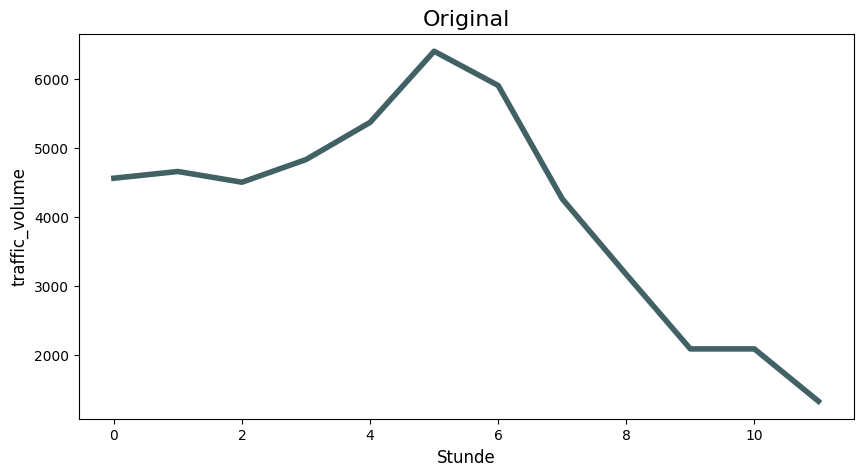

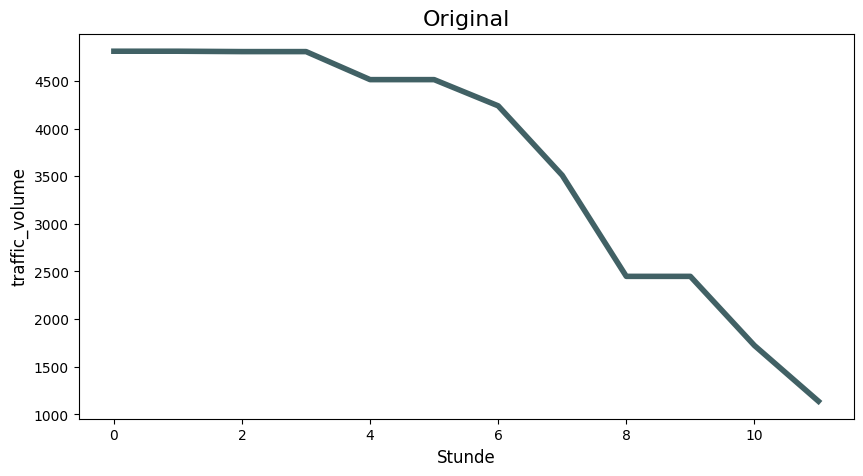

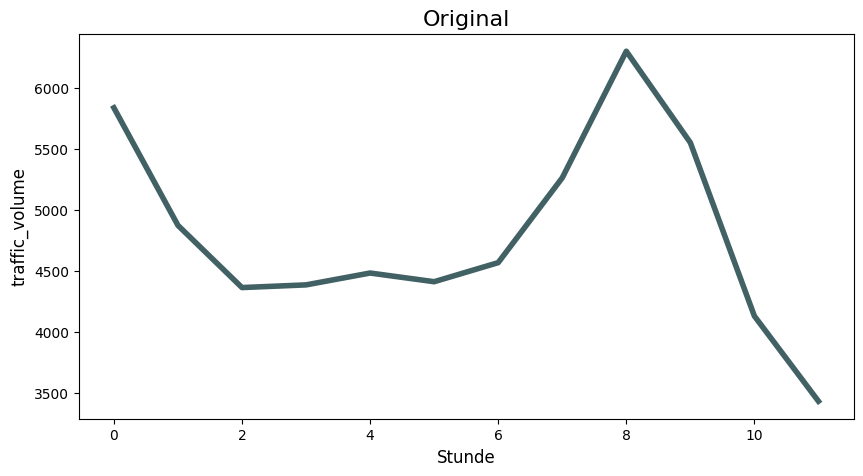

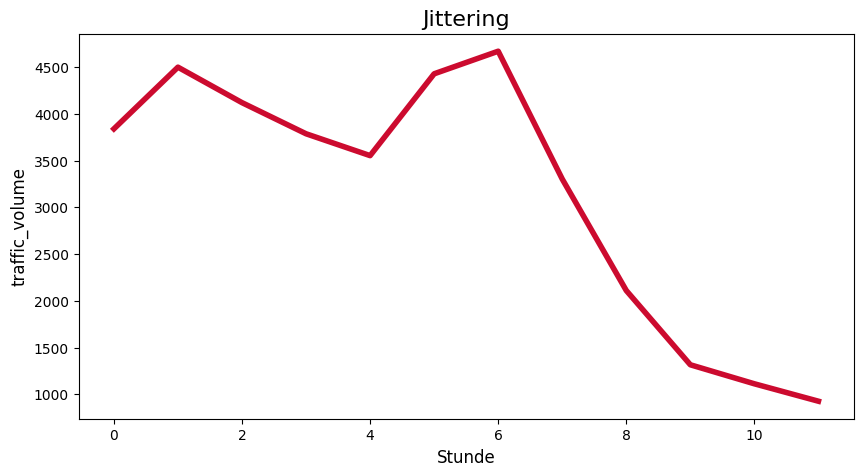

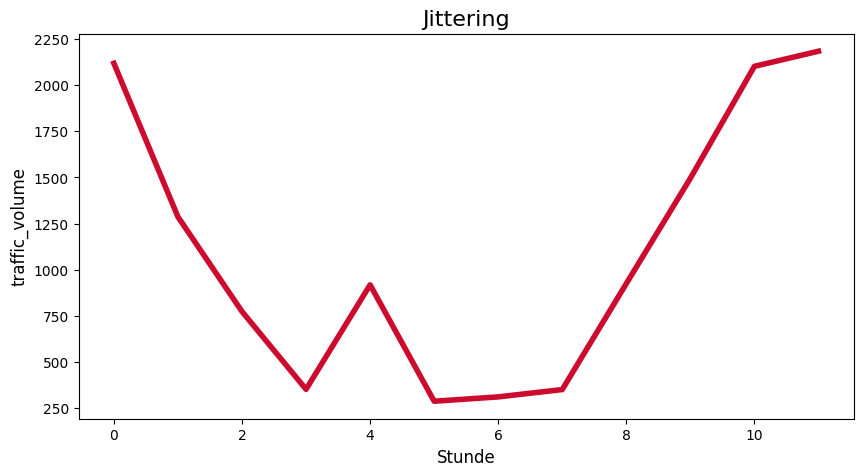

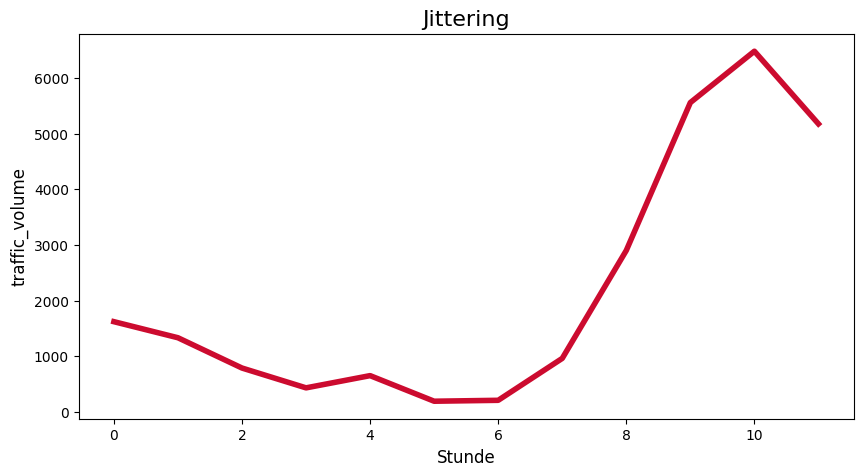

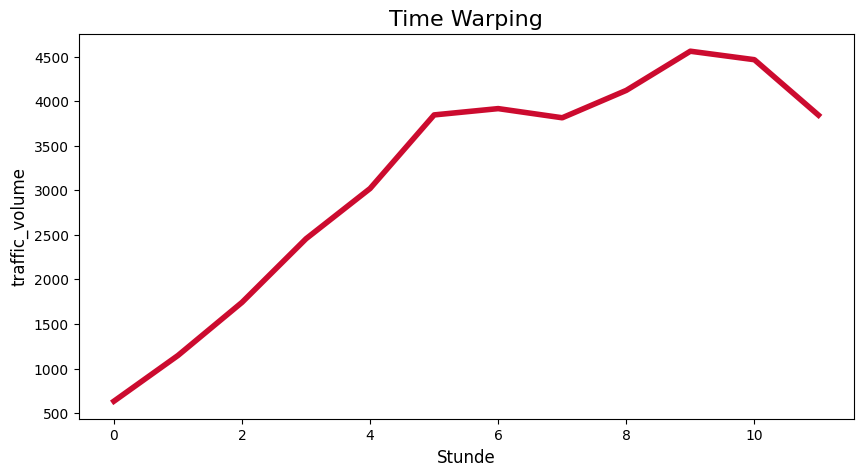

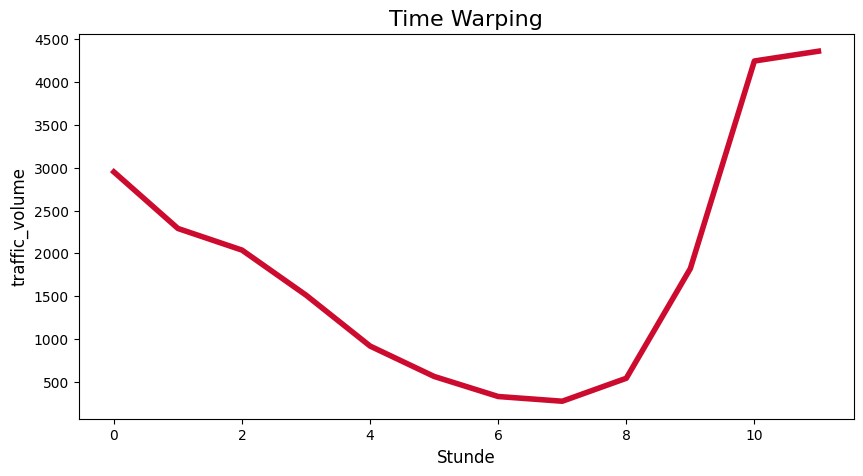

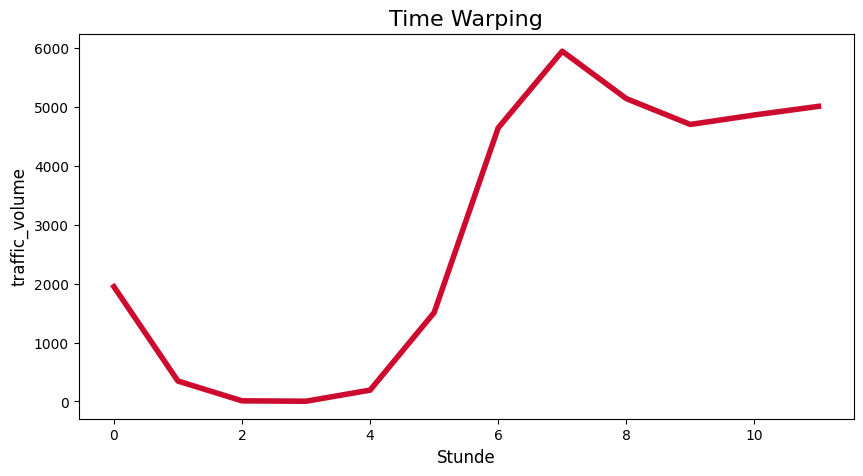

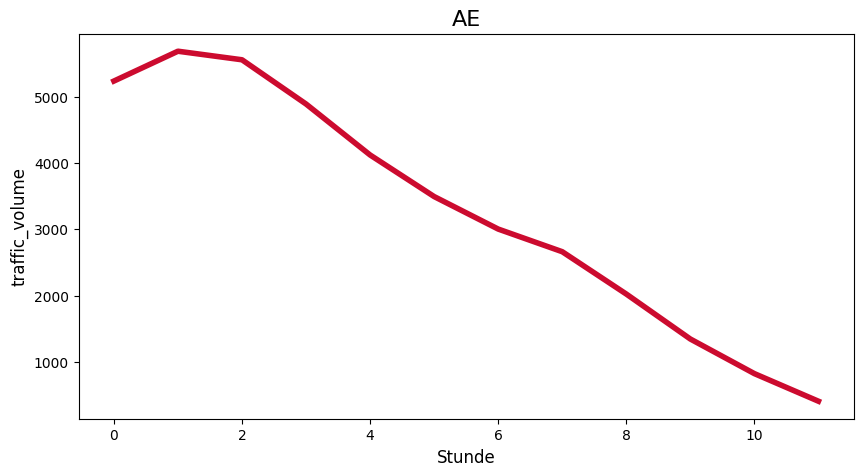

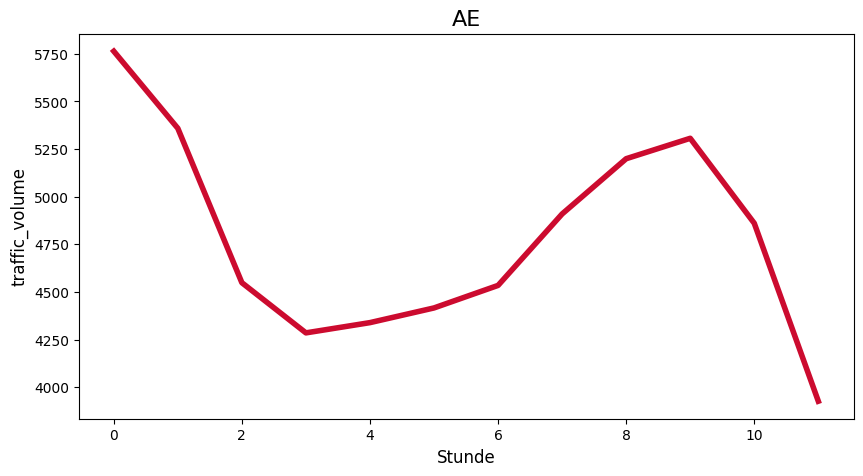

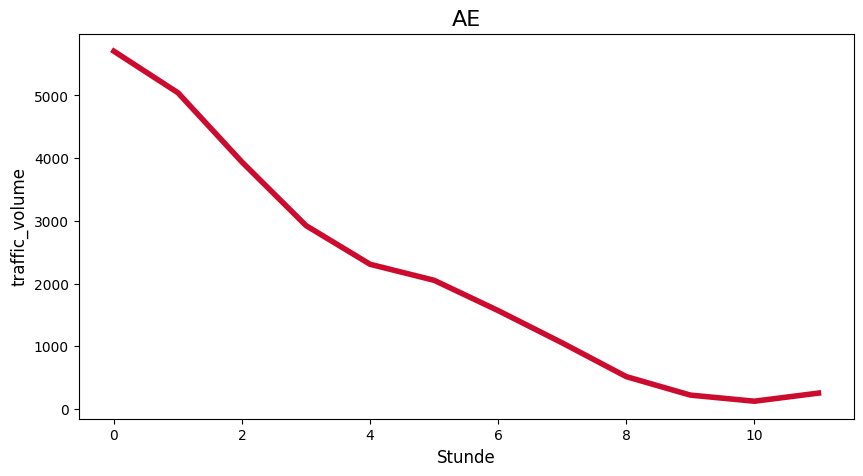

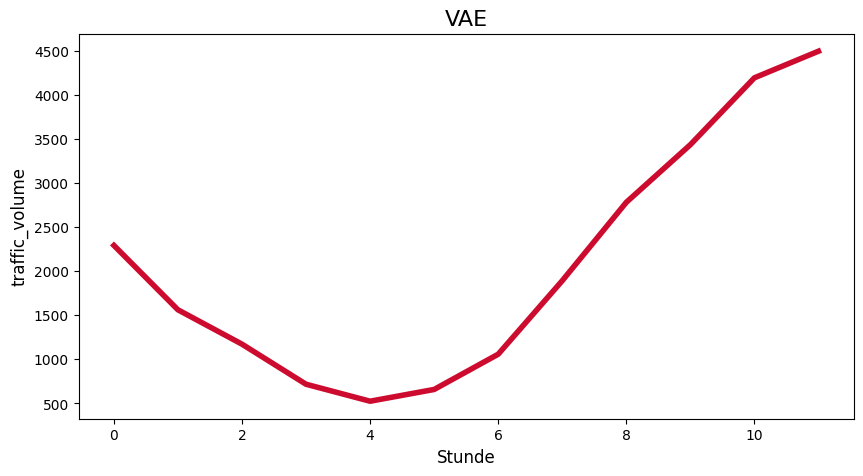

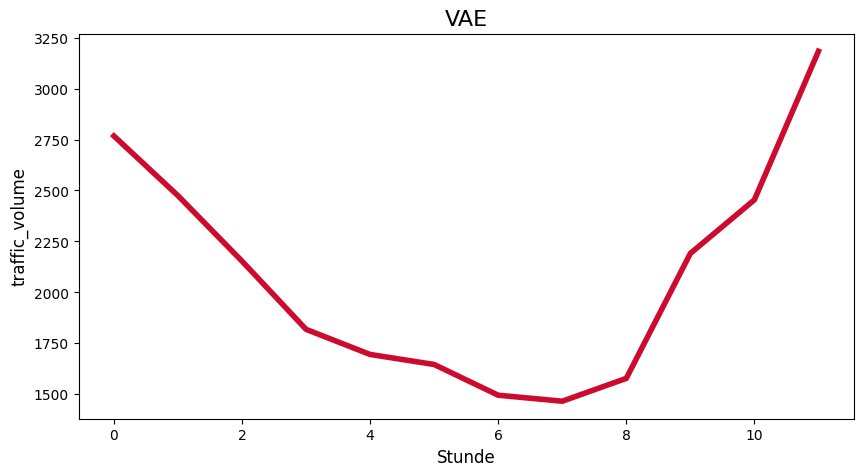

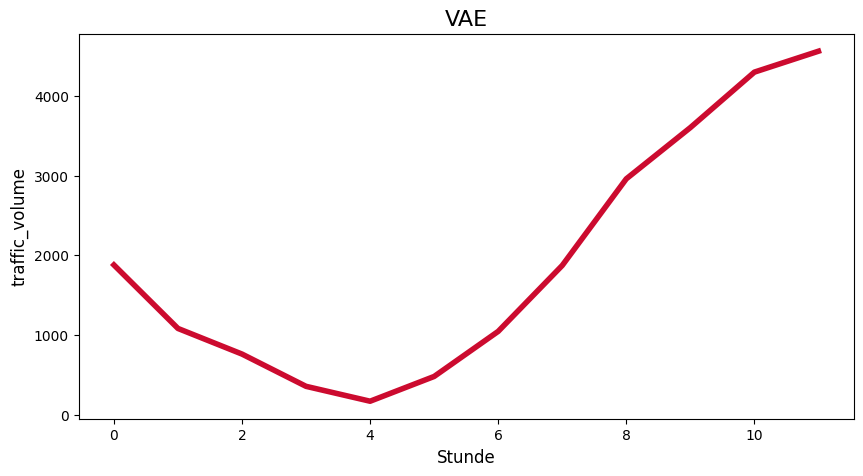

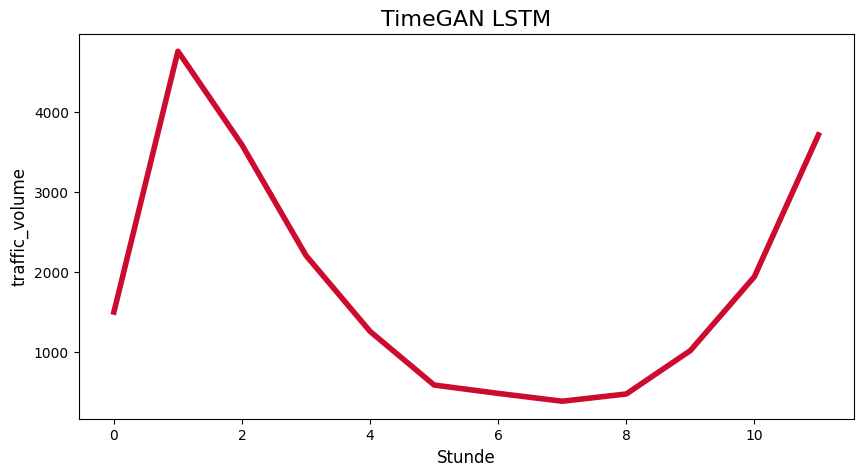

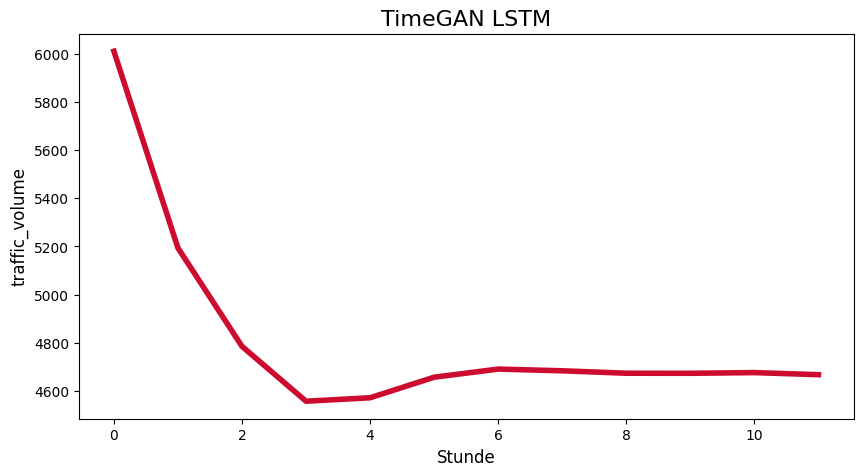

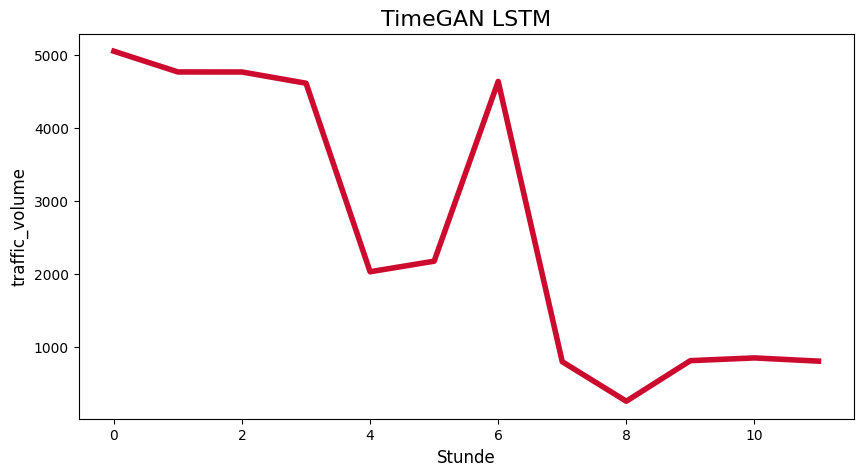

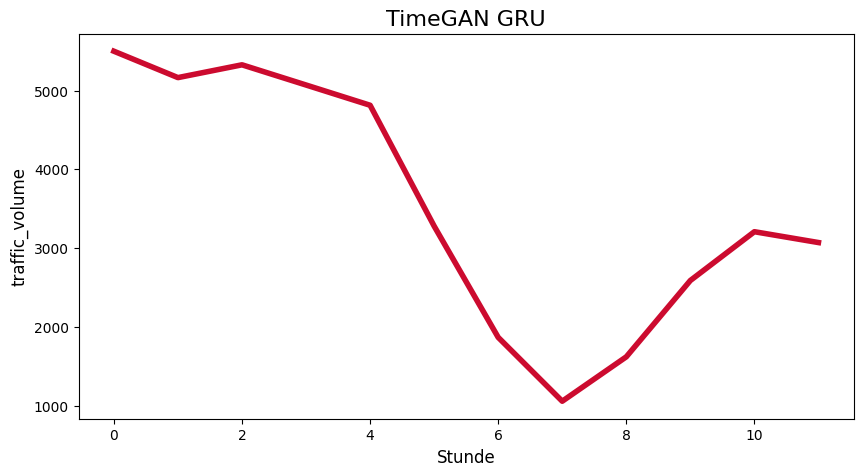

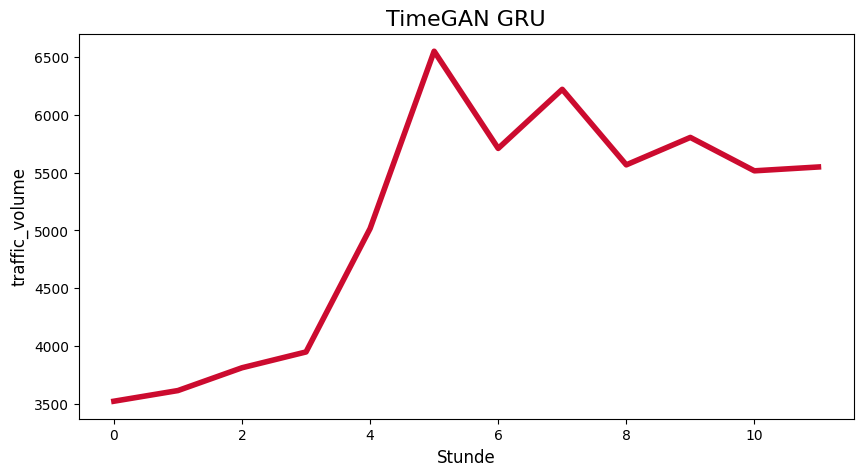

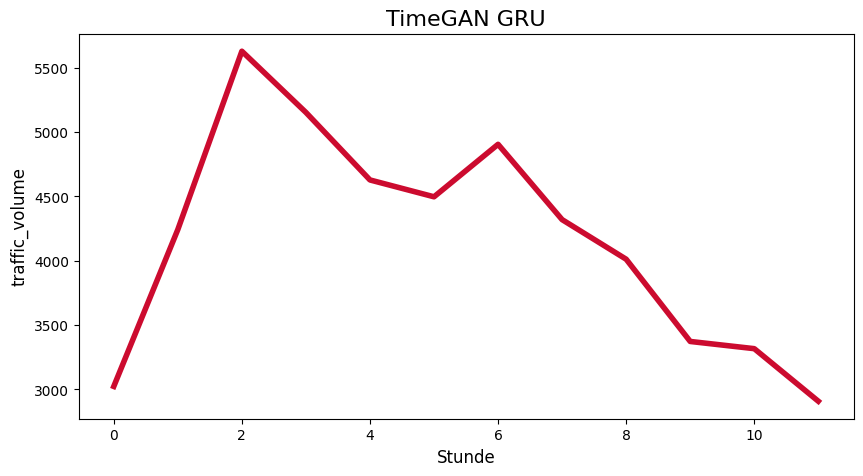

In [45]:
random_real_idx = np.random.choice(data_real_seq_numpy.shape[0], size=3)
for idx in random_real_idx:
    plt.figure(figsize=(10, 5))
    plt.plot(np.arange(data_real_seq_numpy.shape[1]), data_real_seq_numpy[idx, :, 0], linestyle='-', linewidth=4, color=GRAY, label='traffic_volume')
    plt.xlabel('Stunde', fontsize=12)
    plt.ylabel('traffic_volume', fontsize=12)
    plt.title('Original', fontsize=16)
    plt.show()

for dataset in datasets_to_evaluate:
    random_idxs = np.random.choice(dataset.syn_data.shape[0], size=3)
    for idx in random_idxs:
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(dataset.syn_data.shape[1]), dataset.syn_data[idx, :, 0], linestyle='-', linewidth=4, color=RED, label='traffic_volume')
        plt.xlabel('Stunde', fontsize=12)
        plt.ylabel('traffic_volume', fontsize=12)
        plt.title(dataset.type, fontsize=16)
        plt.show()

### Plot Results

/Users/arneallwardt/Documents/-Studium/Bachelorarbeit/time_series_data_augmentation/utilities.py:379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Model'] = filtered_df['Model'].replace('baseline', 'Original')
/Users/arneallwardt/Documents/-Studium/Bachelorarbeit/time_series_data_augmentation/utilities.py:379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Model'] = filtered_df['Model'].replace('baseline', 'Original')


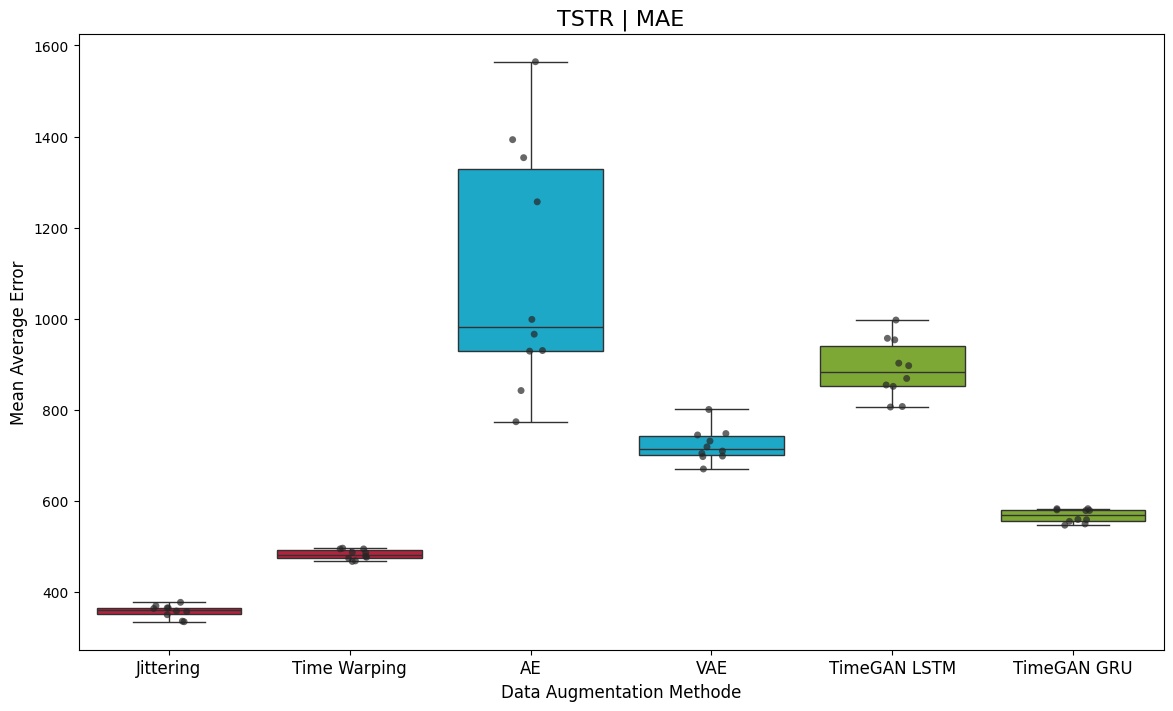

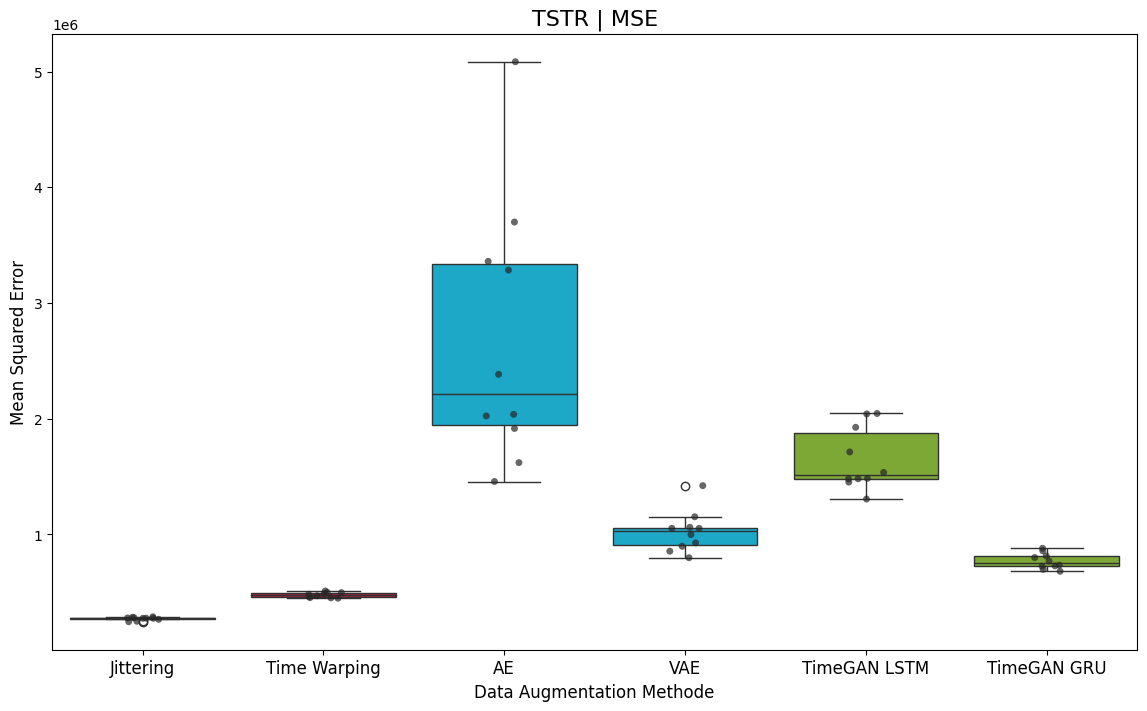

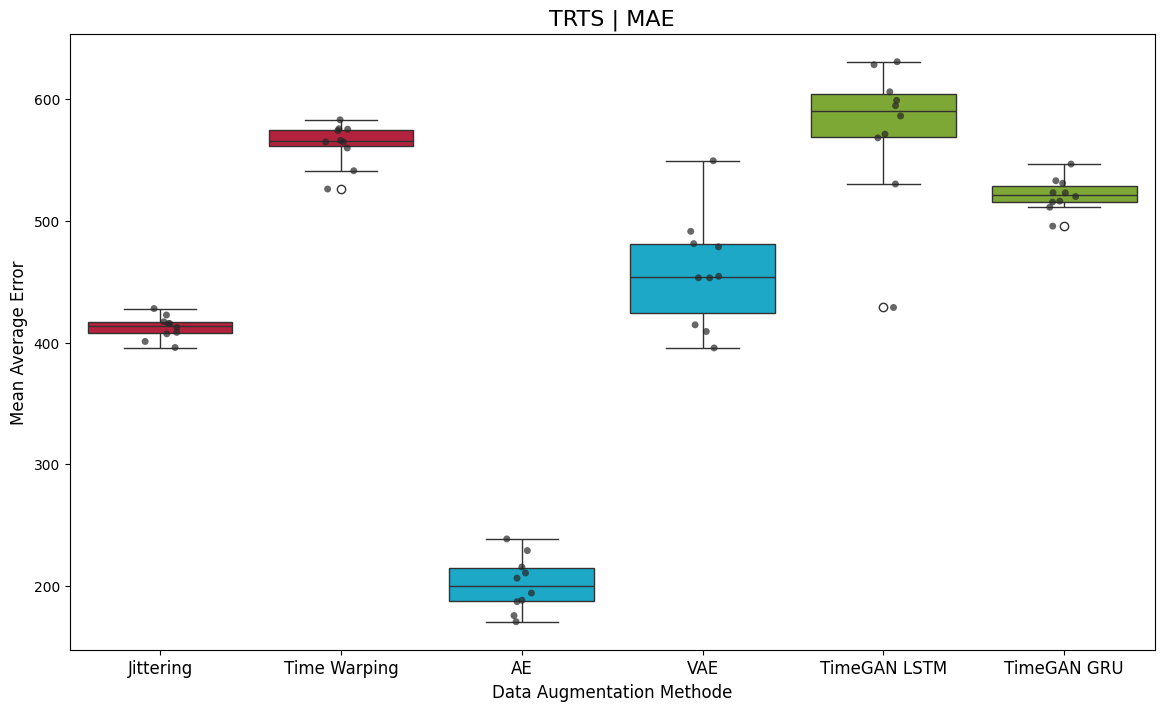

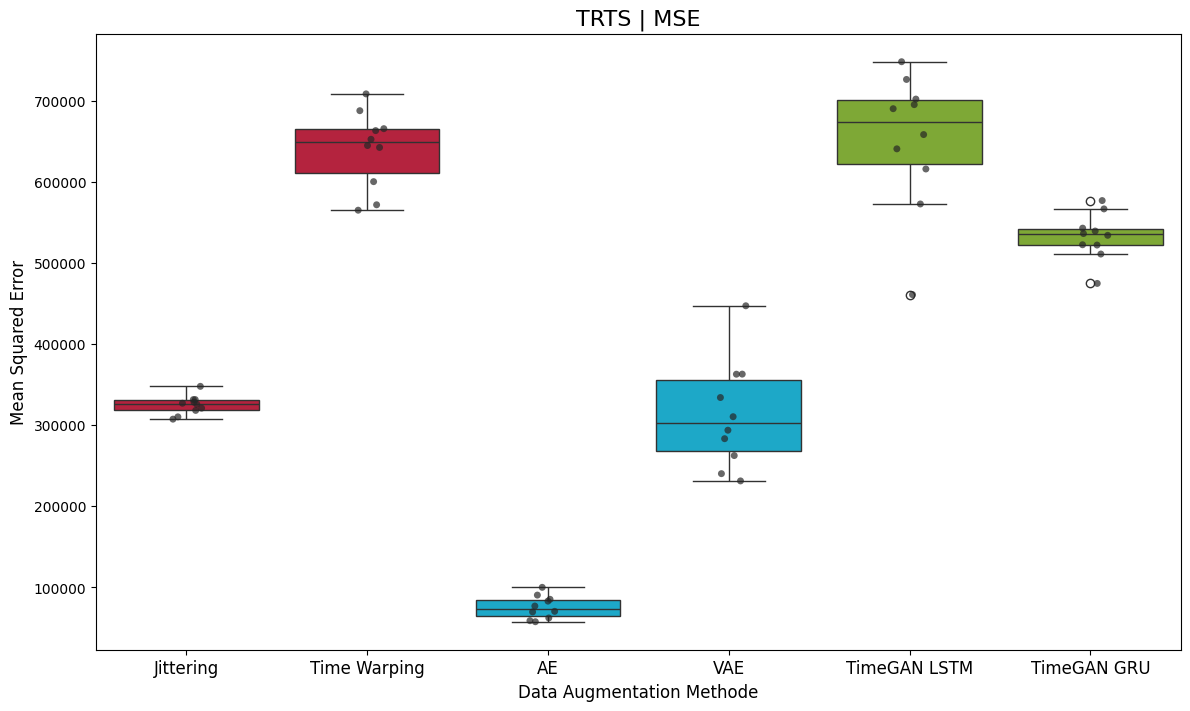

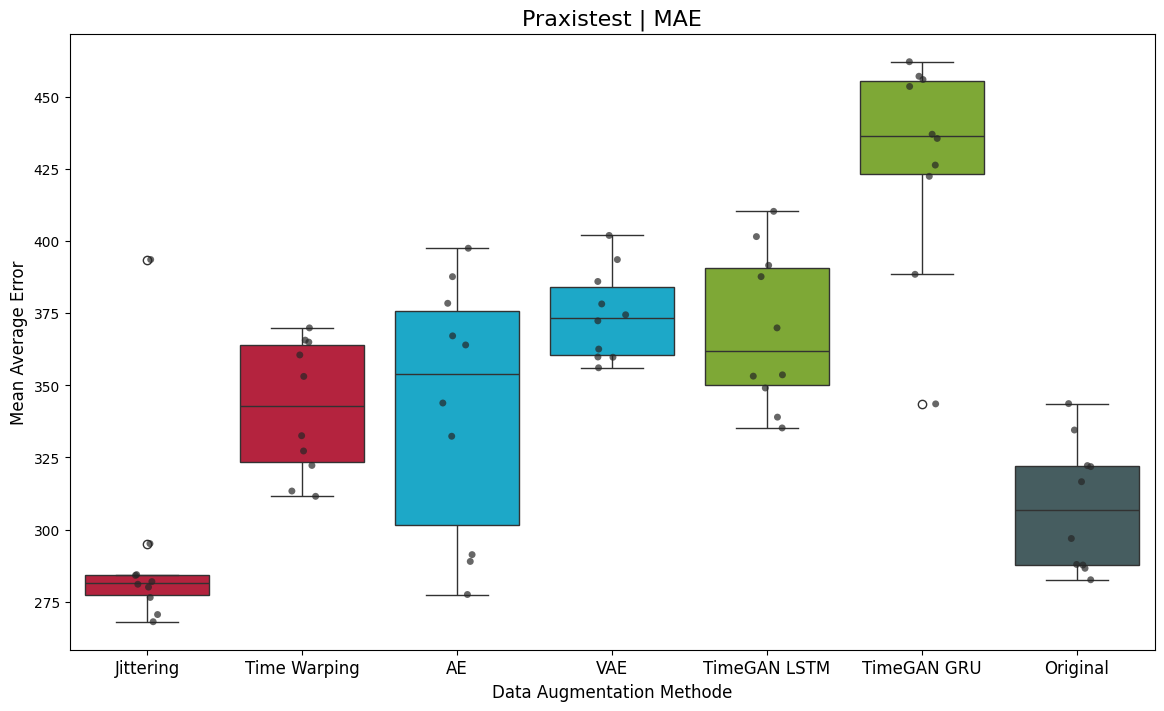

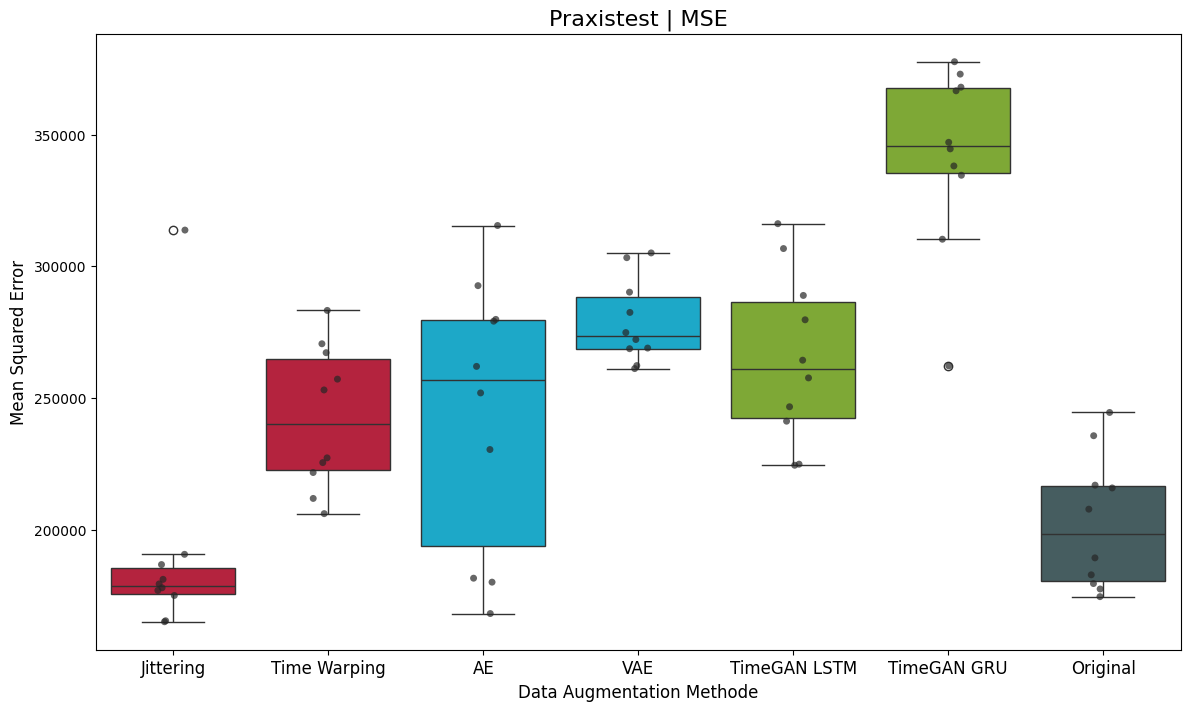

In [46]:
if syn_data_type == 'all':
    plot_multiple_results(eval_datasets, 'MAE', 'TSTR')
    plot_multiple_results(eval_datasets, 'MSE', 'TSTR')
    plot_multiple_results(eval_datasets, 'MAE', 'TRTS')
    plot_multiple_results(eval_datasets, 'MSE', 'TRTS')
    plot_multiple_results(eval_datasets, 'MAE', 'combined')
    plot_multiple_results(eval_datasets, 'MSE', 'combined')
else:
    plot_single_result(eval_datasets, syn_data_type)

### Predictive Error Table

In [55]:
error_results = get_errors(datasets_to_evaluate)
error_results

,Model,Metric,Method,Median,IQR,Mittelwert,Standardabweichung
0,Jittering,MAE,TSTR,361.363274,13.203280,358.022045,13.859317
1,Jittering,MSE,TSTR,276649.403676,11254.252206,272625.482645,14146.439903
2,Jittering,MAE,TRTS,413.935467,9.263829,412.342441,9.634408
3,Jittering,MSE,TRTS,326402.071151,11838.020044,324893.568554,11608.235276
4,Jittering,MAE,combined,281.478467,6.955287,291.517736,36.678137
5,Jittering,MSE,combined,178659.852746,9850.059458,191194.705122,43799.198716
6,Time Warping,MAE,TSTR,482.549951,17.984896,482.608259,10.898169
7,Time Warping,MSE,TSTR,476885.447664,38312.617746,477087.085003,22236.138147
8,Time Warping,MAE,TRTS,565.340007,13.906474,562.990199,17.295305
9,Time Warping,MSE,TRTS,648540.177314,54160.324499,640071.383551,47361.098917


## 3 Discriminative Evaluation

### Get Results

In [47]:
discriminative_model_hyperparameters = {
    "lr": 0.0001,
    "batch_size": 32,
    "hidden_size": 4,
    "num_layers": 2,
    "bidirectional": True,
    "output_logits": True,
    "num_epochs": 1000,
    "type": 'lstm',
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [48]:
# Load discriminative model
discriminative_model = LSTMClassification(
    device=discriminative_model_hyperparameters['device'],
    batch_size=discriminative_model_hyperparameters['batch_size'],
    input_size=data_real_numpy.shape[-1],
    hidden_size=discriminative_model_hyperparameters['hidden_size'],
    num_stacked_layers=discriminative_model_hyperparameters['num_layers'],
    bidirectional=discriminative_model_hyperparameters['bidirectional'],
    output_logits=discriminative_model_hyperparameters['output_logits']
)

# Load model parameters
discriminative_model.load_state_dict(torch.load(f'discriminative/models/{discriminative_model_hyperparameters["type"]}_best_{discriminative_model_hyperparameters["batch_size"]}_{discriminative_model_hyperparameters["hidden_size"]}_{discriminative_model_hyperparameters["num_layers"]}_{"bi" if discriminative_model_hyperparameters["bidirectional"] else ""}.pth'))

<All keys matched successfully>

In [49]:
discriminative_results = pd.DataFrame(columns=['Method', 'Accuracy'])

In [50]:
# get scaler based on discriminative train data to scale test data correctly later on
discriminative_train_data = load_sequential_time_series(SYNTHETIC_DATA_FOLDER / 'discriminative_train' / 'discriminative_train_17502_13_5.csv', shape=(17502, 13, 5))
discriminative_train, _ = train_test_split(discriminative_train_data, split_ratio=0.8)
discriminative_X_train, _ = extract_features_and_targets_clas(discriminative_train)
discriminative_scaler = Scaler(discriminative_X_train)

Extracted features and target from training data.
Shape of X_train: (14001, 12, 5)
Shape of y_train: (14001, 1)


In [51]:
# get results
for eval_dataset in datasets_to_evaluate:
    discriminative_results = get_discriminative_test_performance(
        model=discriminative_model, 
        device=discriminative_model_hyperparameters['device'], 
        test_data=eval_dataset.discriminative_data, 
        scaler=discriminative_scaler,
        method=eval_dataset.type, 
        results=discriminative_results
    )

Extracted features and target from training data.
Shape of X_train: (1459, 12, 5)
Shape of y_train: (1459, 1)
86.223440712817
Extracted features and target from training data.
Shape of X_train: (1459, 12, 5)
Shape of y_train: (1459, 1)
13.091158327621658
Extracted features and target from training data.
Shape of X_train: (1459, 12, 5)
Shape of y_train: (1459, 1)
99.65729952021934
Extracted features and target from training data.
Shape of X_train: (1459, 12, 5)
Shape of y_train: (1459, 1)
74.98286497601097
Extracted features and target from training data.
Shape of X_train: (1459, 12, 5)
Shape of y_train: (1459, 1)
70.2535983550377
Extracted features and target from training data.
Shape of X_train: (1459, 12, 5)
Shape of y_train: (1459, 1)
63.262508567512


/Users/arneallwardt/Documents/-Studium/Bachelorarbeit/time_series_data_augmentation/utilities.py:202: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'Method': method, 'Accuracy': test_acc}])], ignore_index=True)


### Show Results

In [52]:
discriminative_results

,Method,Accuracy
0,Jittering,86.223441
1,Time Warping,13.091158
2,AE,99.657300
3,VAE,74.982865
4,TimeGAN LSTM,70.253598
5,TimeGAN GRU,63.262509


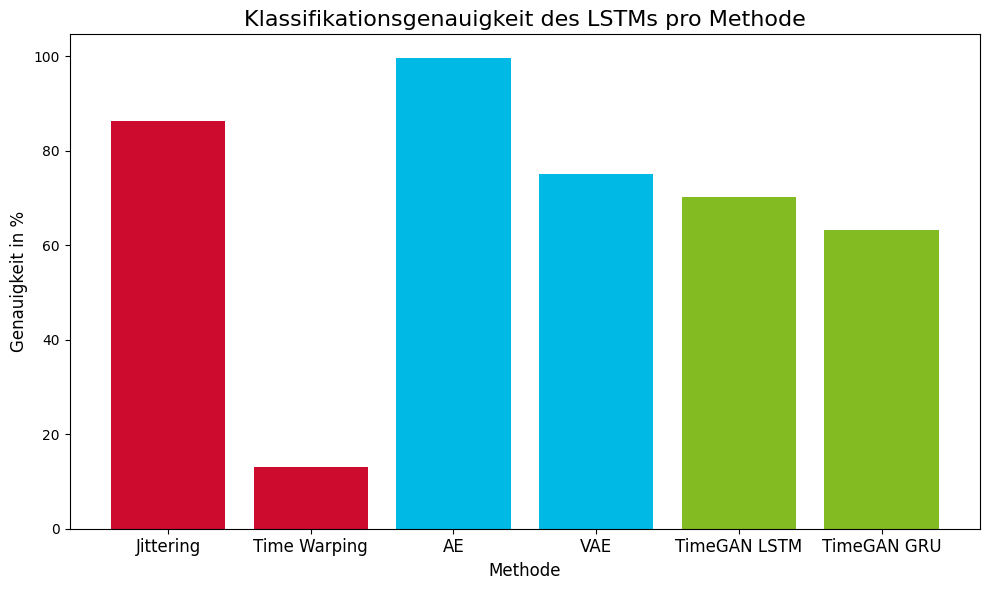

In [53]:
# Plot results
plt.figure(figsize=(10, 6))
plt.bar(discriminative_results['Method'], discriminative_results['Accuracy'], color=MODEL_COLORS.values())

# Diagramm anpassen
plt.xlabel('Methode', fontsize=12)
plt.ylabel('Genauigkeit in %', fontsize=12)
plt.title('Klassifikationsgenauigkeit des LSTMs pro Methode', fontsize=16)
plt.xticks(fontsize=12)
plt.tight_layout()

# Diagramm anzeigen
plt.show()

## 4 Visual Evaluation

/Users/arneallwardt/Documents/-Studium/Bachelorarbeit/time_series_data_augmentation/time_series_data_augmentation_venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Number of datasets to evaluate: 6
shape of data before preprocessing: (1000, 12, 5)
shape of data after preprocessing: (1000, 60)
shape of data before preprocessing: (1000, 12, 5)
shape of data after preprocessing: (1000, 60)
(1000, 60) (1000, 60)
shape of data before preprocessing: (1000, 12, 5)
shape of data after preprocessing: (1000, 60)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.144s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1155.091957
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.551731
[t-SNE] KL divergence after 300 iterations: 1.019776
shape of data before preprocessing: (1000, 12, 5)
shape of data after preprocessing: (1000, 60)
(1000, 60) (1000, 60)
shape of data before preprocessing: (1000, 12, 5)
shape of data after preprocessing: (1000, 60)
[t-SN

/Users/arneallwardt/Documents/-Studium/Bachelorarbeit/time_series_data_augmentation/time_series_data_augmentation_venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.889343
[t-SNE] KL divergence after 300 iterations: 1.122643
shape of data before preprocessing: (1000, 12, 5)
shape of data after preprocessing: (1000, 60)
(1000, 60) (1000, 60)
shape of data before preprocessing: (1000, 12, 5)
shape of data after preprocessing: (1000, 60)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.111s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 987.946441


/Users/arneallwardt/Documents/-Studium/Bachelorarbeit/time_series_data_augmentation/time_series_data_augmentation_venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.124660
[t-SNE] KL divergence after 300 iterations: 0.993098
shape of data before preprocessing: (1000, 12, 5)
shape of data after preprocessing: (1000, 60)
(1000, 60) (1000, 60)
shape of data before preprocessing: (1000, 12, 5)
shape of data after preprocessing: (1000, 60)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.094s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1040.203088


/Users/arneallwardt/Documents/-Studium/Bachelorarbeit/time_series_data_augmentation/time_series_data_augmentation_venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.005619
[t-SNE] KL divergence after 300 iterations: 1.071307
shape of data before preprocessing: (1000, 12, 5)
shape of data after preprocessing: (1000, 60)
(1000, 60) (1000, 60)
shape of data before preprocessing: (1000, 12, 5)
shape of data after preprocessing: (1000, 60)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.099s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1318.155040


/Users/arneallwardt/Documents/-Studium/Bachelorarbeit/time_series_data_augmentation/time_series_data_augmentation_venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.888958
[t-SNE] KL divergence after 300 iterations: 1.192146
shape of data before preprocessing: (1000, 12, 5)
shape of data after preprocessing: (1000, 60)
(1000, 60) (1000, 60)
shape of data before preprocessing: (1000, 12, 5)
shape of data after preprocessing: (1000, 60)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.002s...
[t-SNE] Computed neighbors for 2000 samples in 0.116s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1235.739643


/Users/arneallwardt/Documents/-Studium/Bachelorarbeit/time_series_data_augmentation/time_series_data_augmentation_venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.549149
[t-SNE] KL divergence after 300 iterations: 1.197484


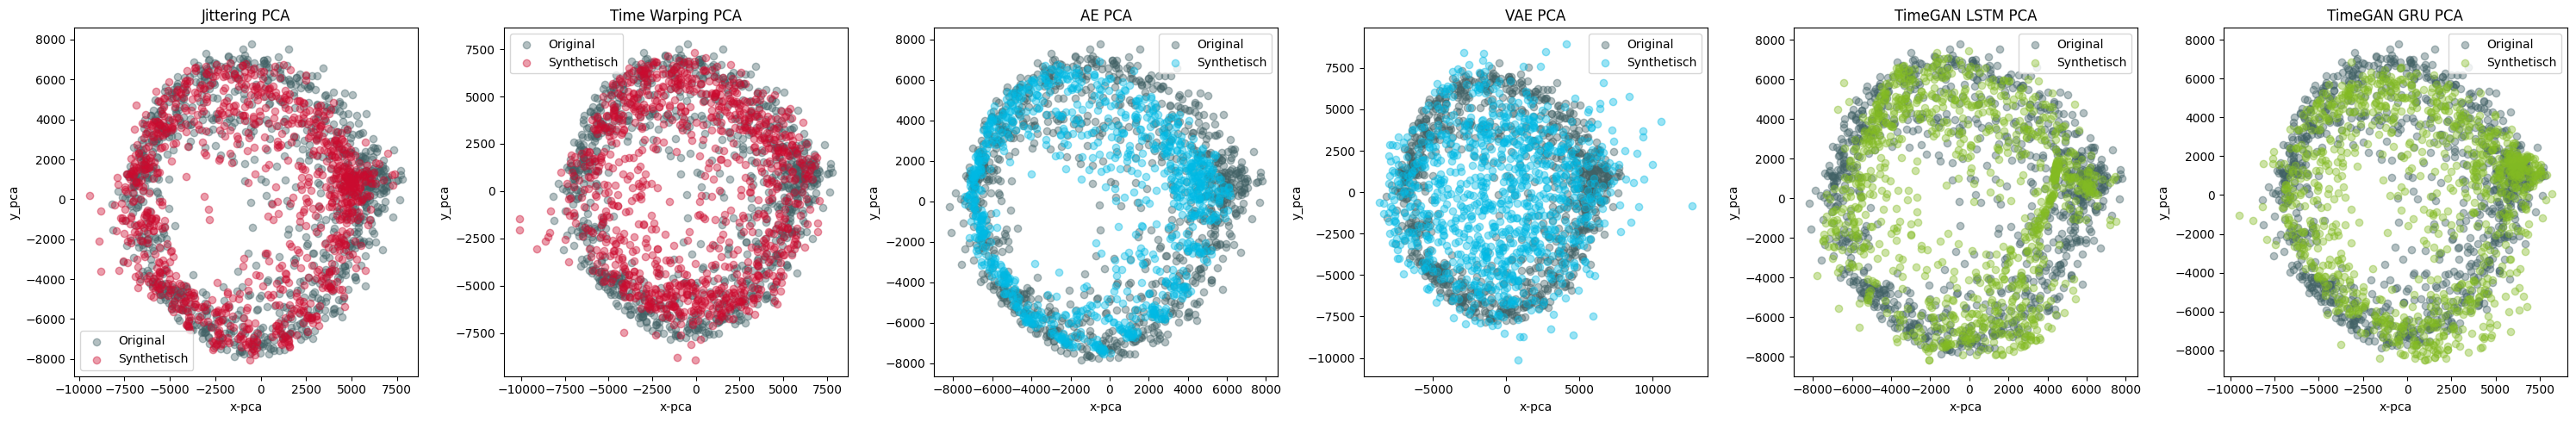

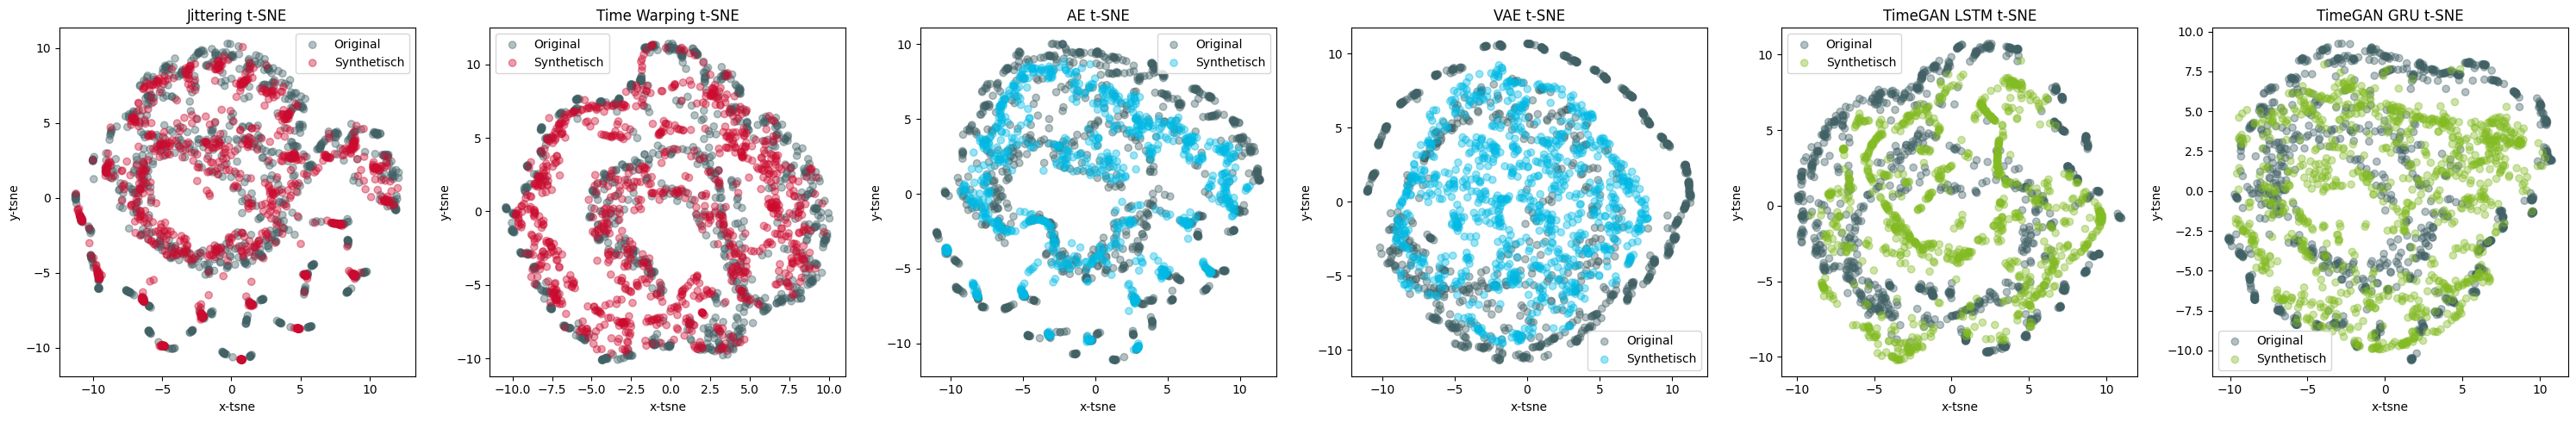

In [54]:
visual_evaluation(data_real=data_real_seq_numpy,
                    eval_datasets=datasets_to_evaluate,
                    verbose=True)

### Beispielaussage:
PCA-Analyse von Realen und Synthetischen Daten
Um die Ähnlichkeit zwischen den realen und synthetischen Daten zu bewerten, wurde eine Principal Component Analysis (PCA) durchgeführt. Die PCA reduziert die Dimensionalität der Daten und projiziert sie auf eine zweidimensionale Ebene, wobei die Hauptkomponenten beibehalten werden, die den größten Teil der Varianz erklären.

Abbildung X zeigt den PCA-Plot der realen (rote Punkte) und synthetischen Daten (blaue Punkte). Die folgenden Beobachtungen können gemacht werden:

Verteilung und Clusterbildung:

Die roten Punkte, die die realen Daten repräsentieren, sind in einem spezifischen Bereich konzentriert.
Die blauen Punkte, die die synthetischen Daten darstellen, zeigen eine größere Verteilung und decken einen breiteren Bereich ab.
Ähnlichkeit und Unterschiede:

Die Tatsache, dass die synthetischen Daten eine größere Variabilität aufweisen, könnte darauf hinweisen, dass sie eine breitere Vielfalt an Mustern generieren.
Die Cluster der realen und synthetischen Daten überlappen sich teilweise, was darauf hindeutet, dass die synthetischen Daten einige der Eigenschaften der realen Daten gut nachahmen. Allerdings gibt es auch Bereiche, in denen die synthetischen Daten stark von den realen Daten abweichen, was auf Unterschiede in den zugrunde liegenden Verteilungen hinweist.
Schlussfolgerung:

Die PCA-Analyse zeigt, dass die synthetischen Daten in gewissem Maße die Struktur der realen Daten einfangen, jedoch eine größere Variabilität aufweisen.
Weitere Untersuchungen und Anpassungen am Generierungsprozess der synthetischen Daten könnten notwendig sein, um deren Genauigkeit und Übereinstimmung mit den realen Daten zu verbessern.